<a href="https://colab.research.google.com/github/syahputra21/Deep-Learning_Tugas-2_Klasifikasi-Pisau/blob/main/Tugas2_Deep%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import library yang diperlukan
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path ke dataset di Google Drive
dataset_path = '/content/drive/MyDrive/Dataset_Pisau'  # Ganti dengan path dataset Anda

# Periksa apakah dataset ada
if not os.path.exists(dataset_path):
    raise Exception(f"Dataset tidak ditemukan di {dataset_path}. Pastikan path benar.")

# Kelas-kelas yang ada
class_names = sorted(os.listdir(dataset_path))
num_classes = len(class_names)

print(f"Ditemukan {num_classes} kelas: {class_names}")
print("Contoh file di kelas pertama:", os.listdir(os.path.join(dataset_path, class_names[0]))[:5])

Ditemukan 4 kelas: ['Cutter', 'Pen_Cutter', 'Pisau Dapur', 'Pisau_Daging']
Contoh file di kelas pertama: ['  (375).jpg', '  (373).jpg', '  (370).jpg', '  (376).jpg', '  (372).jpg']


In [ ]:
# Parameter
batch_size = 32
img_height = 224  # MobileNetV2 default input size
img_width = 224
validation_split = 0.2  # 20% untuk validasi

# Data generator dengan augmentasi untuk training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=validation_split
)

# Data generator untuk validasi (hanya rescaling)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=validation_split)

# Training dataset
train_ds = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation dataset
val_ds = val_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 968 images belonging to 4 classes.
Found 242 images belonging to 4 classes.


In [ ]:
# Load MobileNetV2 base model tanpa top layer dan dengan weights imagenet
base_model = MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Freeze base model
base_model.trainable = False

# Bangun model lengkap
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

# Compile model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Custom callback untuk menampilkan semua metrik
class TrainingProgressCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        print(f"{'Epoch':<7}{'Train Loss':<12}{'Train Acc':<12}{'Val Loss':<12}{'Val Acc':<12}")
        print("-" * 55)

    def on_epoch_end(self, epoch, logs=None):
        train_loss = logs.get('loss', 0)
        train_acc = logs.get('accuracy', 0)
        val_loss = logs.get('val_loss', 0)
        val_acc = logs.get('val_accuracy', 0)
        print(f"{epoch + 1:<7}{train_loss:<12.4f}{train_acc:<12.4f}{val_loss:<12.4f}{val_acc:<12.4f}")

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

# Training
epochs = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping, checkpoint, TrainingProgressCallback()],
    verbose=1  # Tetap pertahankan progress bar default
)

# Menampilkan nilai terbaik
best_epoch = np.argmin(history.history['val_loss'])
print("\nBest Epoch Summary:")
print(f"{'Epoch':<7}{'Train Loss':<12}{'Train Acc':<12}{'Val Loss':<12}{'Val Acc':<12}")
print("-" * 55)
print(f"{best_epoch + 1:<7}"
      f"{history.history['loss'][best_epoch]:<12.4f}"
      f"{history.history['accuracy'][best_epoch]:<12.4f}"
      f"{history.history['val_loss'][best_epoch]:<12.4f}"
      f"{history.history['val_accuracy'][best_epoch]:<12.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch  Train Loss  Train Acc   Val Loss    Val Acc     
-------------------------------------------------------
Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.3519 - loss: 1.5902 

1      1.5042      0.3585      1.2321      0.4669      
31/31 ━━━━━━━━━━━━━━━━━━━━ 553s 18s/step - accuracy: 0.3521 - loss: 1.5875 - val_accuracy: 0.4669 - val_loss: 1.2321
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.3660 - loss: 1.3638

2      1.3181      0.3967      1.0787      0.5537      
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 682ms/step - accuracy: 0.3669 - loss: 1.3624 - val_accuracy: 0.5537 - val_loss: 1.0787
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.4758 - loss: 1.1881

3      1.1411      0.5103      0.9371      0.6405      
31/31 ━━━━━━━━━━━━━━━━━━━━ 42s 703ms/step - accuracy: 0.4768 - loss: 1.1866 - val_accuracy: 0.6405 - val_loss: 0.9371
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.5567 - loss: 1.0563

4      1.0063      0.6033      0.8290      0.7107      
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 680ms/step - accuracy: 0.5582 - loss: 1.0547 - val_accuracy: 0.7107 - val_loss: 0.8290
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - accuracy: 0.6467 - loss: 0.9160

5      0.8918      0.6591      0.7356      0.7603      
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 689ms/step - accuracy: 0.6471 - loss: 0.9153 - val_accuracy: 0.7603 - val_loss: 0.7356
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.6870 - loss: 0.8247

6      0.8208      0.6973      0.6652      0.7934      
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 672ms/step - accuracy: 0.6873 - loss: 0.8246 - val_accuracy: 0.7934 - val_loss: 0.6652
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.7376 - loss: 0.7023

7      0.7270      0.7366      0.6047      0.8223      
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 674ms/step - accuracy: 0.7375 - loss: 0.7031 - val_accuracy: 0.8223 - val_loss: 0.6047
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.7725 - loss: 0.6691

8      0.6723      0.7727      0.5535      0.8471      
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 713ms/step - accuracy: 0.7725 - loss: 0.6692 - val_accuracy: 0.8471 - val_loss: 0.5535
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.8002 - loss: 0.6522

9      0.6448      0.8006      0.5118      0.8595      
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 670ms/step - accuracy: 0.8002 - loss: 0.6520 - val_accuracy: 0.8595 - val_loss: 0.5118
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.8157 - loss: 0.5905

10     0.6090      0.7965      0.4774      0.8760      
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 691ms/step - accuracy: 0.8151 - loss: 0.5911 - val_accuracy: 0.8760 - val_loss: 0.4774
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.8151 - loss: 0.5727

11     0.5547      0.8357      0.4452      0.8884      
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 715ms/step - accuracy: 0.8157 - loss: 0.5721 - val_accuracy: 0.8884 - val_loss: 0.4452
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.8414 - loss: 0.4998

12     0.5114      0.8409      0.4232      0.8926      
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 677ms/step - accuracy: 0.8413 - loss: 0.5001 - val_accuracy: 0.8926 - val_loss: 0.4232
Epoch 13/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.8405 - loss: 0.504713     0.4943      0.8450      0.4004      0.8926      
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 659ms/step - accuracy: 0.8407 - loss: 0.5044 - val_accuracy: 0.8926 - val_loss: 0.4004
Epoch 14/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.8536 - loss: 0.4757

14     0.4634      0.8554      0.3791      0.9008      
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 676ms/step - accuracy: 0.8537 - loss: 0.4754 - val_accuracy: 0.9008 - val_loss: 0.3791
Epoch 15/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.8433 - loss: 0.460415     0.4490      0.8605      0.3635      0.9008      
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 671ms/step - accuracy: 0.8438 - loss: 0.4600 - val_accuracy: 0.9008 - val_loss: 0.3635
Epoch 16/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.8697 - loss: 0.4272

16     0.4332      0.8698      0.3503      0.9050      
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 663ms/step - accuracy: 0.8697 - loss: 0.4274 - val_accuracy: 0.9050 - val_loss: 0.3503
Epoch 17/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.8844 - loss: 0.4088

17     0.4131      0.8760      0.3324      0.9091      
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 703ms/step - accuracy: 0.8841 - loss: 0.4089 - val_accuracy: 0.9091 - val_loss: 0.3324
Epoch 18/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.8913 - loss: 0.380718     0.3924      0.8843      0.3226      0.9050      
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 654ms/step - accuracy: 0.8910 - loss: 0.3811 - val_accuracy: 0.9050 - val_loss: 0.3226
Epoch 19/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.8628 - loss: 0.402319     0.3881      0.8771      0.3108      0.9091      
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 637ms/step - accuracy: 0.8632 - loss: 0.4019 - val_accuracy: 0.9091 - val_loss: 0.3108
Epoch 20/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.8818 - loss: 0.378420     0.3850      0.8698      0.3028      0.9091      
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 675ms/step - accuracy: 0.8814 - loss: 0.3786 - val_accuracy: 0.9091 - val_loss: 0.3028
Epoch 21/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 575m

22     0.3396      0.9008      0.2816      0.9256      
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 705ms/step - accuracy: 0.8978 - loss: 0.3617 - val_accuracy: 0.9256 - val_loss: 0.2816
Epoch 23/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.9061 - loss: 0.332223     0.3557      0.8915      0.2749      0.9256      
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 677ms/step - accuracy: 0.9057 - loss: 0.3329 - val_accuracy: 0.9256 - val_loss: 0.2749
Epoch 24/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.9091 - loss: 0.324324     0.3317      0.8998      0.2662      0.9256      
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 628ms/step - accuracy: 0.9088 - loss: 0.3246 - val_accuracy: 0.9256 - val_loss: 0.2662
Epoch 25/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.8939 - loss: 0.3475

25     0.3237      0.9008      0.2590      0.9339      
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 709ms/step - accuracy: 0.8942 - loss: 0.3467 - val_accuracy: 0.9339 - val_loss: 0.2590
Epoch 26/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.8909 - loss: 0.322926     0.3284      0.8895      0.2547      0.9256      
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 666ms/step - accuracy: 0.8909 - loss: 0.3231 - val_accuracy: 0.9256 - val_loss: 0.2547
Epoch 27/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.8980 - loss: 0.319727     0.3158      0.9019      0.2478      0.9339      
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 628ms/step - accuracy: 0.8981 - loss: 0.3196 - val_accuracy: 0.9339 - val_loss: 0.2478
Epoch 28/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.8834 - loss: 0.3186

28     0.3151      0.8905      0.2419      0.9380      
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 692ms/step - accuracy: 0.8836 - loss: 0.3185 - val_accuracy: 0.9380 - val_loss: 0.2419
Epoch 29/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.9061 - loss: 0.300629     0.2978      0.9081      0.2363      0.9380      
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 627ms/step - accuracy: 0.9061 - loss: 0.3005 - val_accuracy: 0.9380 - val_loss: 0.2363
Epoch 30/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.9053 - loss: 0.2882

30     0.2819      0.9091      0.2300      0.9463      
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 694ms/step - accuracy: 0.9055 - loss: 0.2880 - val_accuracy: 0.9463 - val_loss: 0.2300
Epoch 31/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.9232 - loss: 0.262131     0.2698      0.9163      0.2262      0.9380      
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 632ms/step - accuracy: 0.9230 - loss: 0.2624 - val_accuracy: 0.9380 - val_loss: 0.2262
Epoch 32/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - accuracy: 0.9109 - loss: 0.273132     0.2649      0.9236      0.2251      0.9380      
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 658ms/step - accuracy: 0.9113 - loss: 0.2729 - val_accuracy: 0.9380 - val_loss: 0.2251
Epoch 33/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.9295 - loss: 0.241433     0.2662      0.9174      0.2195      0.9421      
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 632ms/step - accuracy: 0.9291 - loss: 0.2422 - val_accuracy: 0.9421 - val_loss: 0.2195
Epoch 34/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 613m

34     0.2604      0.9267      0.2144      0.9504      
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 700ms/step - accuracy: 0.9352 - loss: 0.2472 - val_accuracy: 0.9504 - val_loss: 0.2144
Epoch 35/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.9202 - loss: 0.271235     0.2656      0.9205      0.2114      0.9463      
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 641ms/step - accuracy: 0.9202 - loss: 0.2710 - val_accuracy: 0.9463 - val_loss: 0.2114
Epoch 36/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.9081 - loss: 0.280736     0.2691      0.9174      0.2087      0.9421      
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 623ms/step - accuracy: 0.9084 - loss: 0.2803 - val_accuracy: 0.9421 - val_loss: 0.2087
Epoch 37/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.9106 - loss: 0.272037     0.2780      0.9101      0.2066      0.9421      
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 665ms/step - accuracy: 0.9106 - loss: 0.2722 - val_accuracy: 0.9421 - val_loss: 0.2066
Epoch 38/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 576m

38     0.2600      0.9163      0.2021      0.9545      
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 665ms/step - accuracy: 0.9166 - loss: 0.2416 - val_accuracy: 0.9545 - val_loss: 0.2021
Epoch 39/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.9322 - loss: 0.245239     0.2471      0.9318      0.1976      0.9504      
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 662ms/step - accuracy: 0.9321 - loss: 0.2453 - val_accuracy: 0.9504 - val_loss: 0.1976
Epoch 40/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.9259 - loss: 0.240840     0.2384      0.9256      0.1963      0.9545      
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 629ms/step - accuracy: 0.9259 - loss: 0.2408 - val_accuracy: 0.9545 - val_loss: 0.1963
Epoch 41/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.9385 - loss: 0.216441     0.2309      0.9256      0.1922      0.9504      
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 659ms/step - accuracy: 0.9381 - loss: 0.2168 - val_accuracy: 0.9504 - val_loss: 0.1922
Epoch 42/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 574m

43     0.2249      0.9256      0.1871      0.9628      
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 695ms/step - accuracy: 0.9217 - loss: 0.2368 - val_accuracy: 0.9628 - val_loss: 0.1871
Epoch 44/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.9290 - loss: 0.232244     0.2168      0.9370      0.1853      0.9587      
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 637ms/step - accuracy: 0.9293 - loss: 0.2317 - val_accuracy: 0.9587 - val_loss: 0.1853
Epoch 45/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.9429 - loss: 0.195845     0.2013      0.9401      0.1813      0.9504      
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 630ms/step - accuracy: 0.9428 - loss: 0.1960 - val_accuracy: 0.9504 - val_loss: 0.1813
Epoch 46/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.9304 - loss: 0.224746     0.2260      0.9277      0.1804      0.9628      
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 672ms/step - accuracy: 0.9304 - loss: 0.2247 - val_accuracy: 0.9628 - val_loss: 0.1804
Epoch 47/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 572m

47     0.2184      0.9390      0.1782      0.9669      
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 659ms/step - accuracy: 0.9306 - loss: 0.2353 - val_accuracy: 0.9669 - val_loss: 0.1782
Epoch 48/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.9208 - loss: 0.248848     0.2249      0.9246      0.1744      0.9545      
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 662ms/step - accuracy: 0.9209 - loss: 0.2481 - val_accuracy: 0.9545 - val_loss: 0.1744
Epoch 49/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.9354 - loss: 0.210849     0.2137      0.9349      0.1732      0.9628      
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 632ms/step - accuracy: 0.9354 - loss: 0.2109 - val_accuracy: 0.9628 - val_loss: 0.1732
Epoch 50/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.9320 - loss: 0.225850     0.2146      0.9380      0.1728      0.9669      
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 668ms/step - accuracy: 0.9322 - loss: 0.2255 - val_accuracy: 0.9669 - val_loss: 0.1728

Best Epoch Summary:
Epoch  Train Loss  Train 

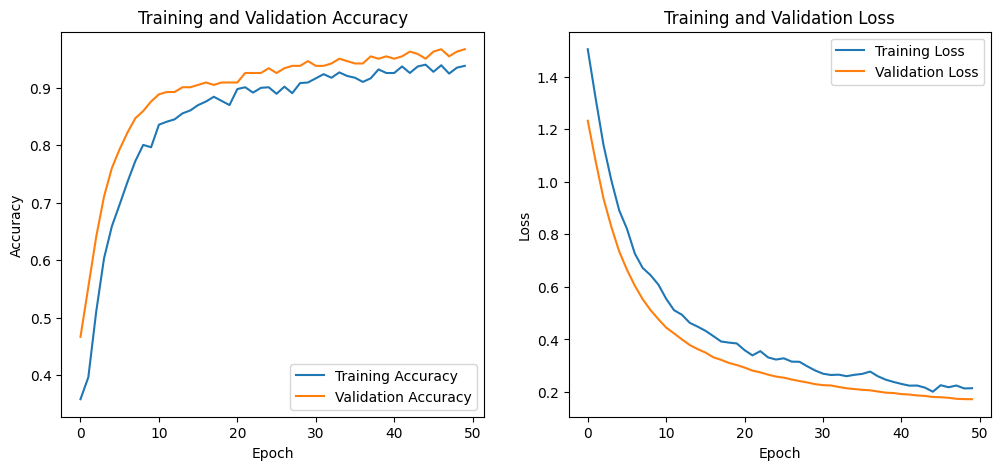

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step - accuracy: 0.9596 - loss: 0.1842

Validation Accuracy: 0.9669


In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluasi pada validation set
val_loss, val_acc = model.evaluate(val_ds)
print(f'\nValidation Accuracy: {val_acc:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 642ms/step

Classification Report:
              precision    recall  f1-score   support

      Cutter       0.97      0.94      0.95        62
  Pen_Cutter       0.92      0.97      0.94        60
 Pisau Dapur       0.98      0.98      0.98        60
Pisau_Daging       1.00      0.98      0.99        60

    accuracy                           0.97       242
   macro avg       0.97      0.97      0.97       242
weighted avg       0.97      0.97      0.97       242



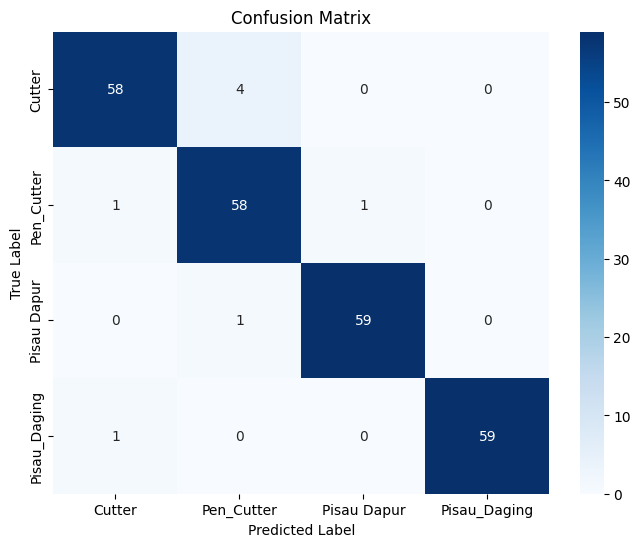

In [ ]:
# Prediksi pada validation set
val_ds.reset()  # Reset generator
y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_ds.classes

# Classification report
print('\nClassification Report:')
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Unfreeze beberapa layer terakhir base model
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Re-compile model dengan learning rate lebih rendah
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Fine-tuning training
fine_tune_epochs = 10
total_epochs = len(history.history['loss']) + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    callbacks=[early_stopping, checkpoint]
)

# Evaluasi setelah fine-tuning
val_loss, val_acc = model.evaluate(val_ds)
print(f'\nValidation Accuracy setelah Fine-Tuning: {val_acc:.4f}')

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 735,684 (2.81 MB)

 Non-trainable params: 1,527,424 (5.83 MB)

Epoch 50/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 918ms/step - accuracy: 0.8912 - loss: 0.3090 - val_accuracy: 0.9628 - val_loss: 0.1664
Epoch 51/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 661ms/step - accuracy: 0.9050 - loss: 0.2986 - val_accuracy: 0.9587 - val_loss: 0.1624
Epoch 52/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 680ms/step - accuracy: 0.9364 - loss: 0.2612 - val_accuracy: 0.9587 - val_loss: 0.1578
Epoch 53/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 661ms/step - accuracy: 0.9312 - loss: 0.2535 - val_accuracy: 0.9587 - val_loss: 0.1532
Epoch 54/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 628ms/step - accuracy: 0.9417 - loss: 0.2170 - val_accuracy: 0.9587 - val_loss: 0.1477
Epoch 55/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 678ms/step - accuracy: 0.9306 - loss: 0.2129 - val_accuracy: 0.9628 - val_loss: 0.1428
Epoch 56/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 640ms/step - accuracy: 0.9242 - loss: 0.2262 - val_accuracy: 0.9587 - val_loss: 0.1378
Epoch 57/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 652ms/step - accuracy: 0.9494 - loss: 0.1874 - 

In [ ]:
# Simpan model akhir
model.save('/content/drive/MyDrive/final_model.h5')
print("Model disimpan di Google Drive")

Model disimpan di Google Drive
